In [1]:
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
import os
from PIL import Image
import sys
import logging
import datetime

# Save log
so = open("data.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so
get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0")

In [3]:
!nvidia-smi

Sun May 28 12:13:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:41:00.0  On |                  N/A |
| 36%   46C    P8    19W / 320W |   4911MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:61:00.0 Off |                  N/A |
| 54%   

In [4]:
# plt.imshow(reverse_transform(image))
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [5]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [6]:
"""
Define noise schedulers
"""
# Define Beta schedulers
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(beta_start, beta_end, timesteps):
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(beta_start, beta_end, timesteps):
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(beta_start, beta_end, timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

### Define Diffusion Class

In [7]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 1000):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        # define beta schedule
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
#         self.betas = cosine_beta_schedule(timesteps)
        # define alphas 
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W) -> [5,3,32,32]
        t: (B,) -> (5,) , including 5 timesteps [  0,  74, 149, 224, 299])
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
        
        # check q(x_t) distribution 
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        # return x_t and noise
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    # check sampling algorithm 2
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        # predicted mean x_(t-1) using Unet
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t
          
        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            # x_(t-1)
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
        
        

In [8]:
# trasfrom PIP image input to tensor input and vice verse
# IMAGE_SHAPE = (32, 32)
# transform = transforms.Compose([
#     transforms.Resize(IMAGE_SHAPE), # Resize the input image
#     transforms.ToTensor(), #CHW (PIL format) to HWC (tensor format) # Convert to torch tensor (normalize scales data into [0,1], we want to add noise to tensor, not PIL format)
#     transforms.Lambda(lambda t: (t * 2) - 1), # shifting the pixel values from the [0,1] range to the [-1,1] range, to make mean = 0 follow normal dist 
# ])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # shift back [-1,1] to [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])


In [9]:
# define a instance of DiffusionModel Class
diffusion_model = DiffusionModel()

### Define position embedding

In [10]:
#This makes the neural network "know" at which particular time step (noise level) it is operating, 
#for every image in a batch
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # dim: dimensionality of the position embeddings
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### Define a Block in Resnet  (no attention)

In [11]:
# missing skip connection?
# improve conv2d using WeightStandardizedConv2d (improved, https://arxiv.org/abs/1903.10520)
# improve BatchNorm using PreNorm https://arxiv.org/abs/1803.08494

class AttentionGate(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.theta = nn.Conv2d(channels, channels // 8, 1, bias=False)
        self.phi = nn.Conv2d(channels, channels // 8, 1, bias=False)
        self.g = nn.Conv2d(channels, channels // 2, 1, bias=False)
        self.out_conv = nn.Conv2d(channels // 2, channels, 1, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.bn = nn.BatchNorm2d(channels // 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        theta = self.theta(x).view(batch_size, -1, height * width)  # B, C//8, H*W
        phi = self.phi(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # B, H*W, C//8
        g = self.g(x).view(batch_size, -1, height * width // 4)  # B, C//2, H*W/4

        attn = self.softmax(torch.bmm(theta, phi))  # B, H*W, H*W
        attn_g = torch.bmm(g, attn).view(batch_size, -1, height, width)  # B, C//2, H, W

        out = self.bn(attn_g)
        out = self.relu(out)
        out = self.out_conv(out)

        return out

    
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()
        
        # TODO Mark: Attention Gate implemetation
#         self.attn = AttentionGate(channels_out)

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

### Define Unet

In [13]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

### Load dataset

In [14]:
BATCH_SIZE = 64
IMG_SIZE = 32
NO_EPOCHS = 600
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [15]:
def custom_load_dataset(data_dir):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    # Load the images from a directory using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform=data_transform)
    # Extract the images and labels from the dataset
#     images, labels = zip(*dataset)
#     return images, labels
    return dataset

def custom_load_dataset_center(data_dir):
    brain_transforms = [
        # Convert to grayscale
#         transforms.Grayscale(),
        # Apply intensity thresholding to isolate the brain region
        transforms.Lambda(lambda x: x.point(lambda p: p > 120 and 255)),
        # Crop the brain region using a bounding box
        transforms.Lambda(lambda x: x.crop(x.getbbox())),
        # Resize the image to the desired size
        transforms.Resize((IMG_SIZE, IMG_SIZE))
    ]
    # Define the standard data transforms
    standard_transforms = [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ]
    # Combine the transforms using the Compose method
    data_transform = transforms.Compose(brain_transforms + standard_transforms)
    # Load the images from a directory using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform=data_transform)
    return dataset

In [16]:
train_data_dir = '/home/mark/Mark/DF/MRI/train'
train_data = custom_load_dataset(train_data_dir)
# train_data = custom_load_dataset_center(train_data_dir)
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_data_dir = '/home/mark/Mark/DF/MRI/test'
test_data = custom_load_dataset(test_data_dir)
# test_data = custom_load_dataset_center(test_data_dir)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [18]:
train_data

Dataset ImageFolder
    Number of datapoints: 2942
    Root location: /home/mark/Mark/DF/MRI/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )

In [19]:
test_data

Dataset ImageFolder
    Number of datapoints: 197
    Root location: /home/mark/Mark/DF/MRI/test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )

In [20]:
#TEST
batch, label = next(iter(testloader))
print(f"Feature batch shape: {batch.size()}")
print(f"Labels batch shape: {label.size()}")

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


In [21]:
type(testloader)

torch.utils.data.dataloader.DataLoader

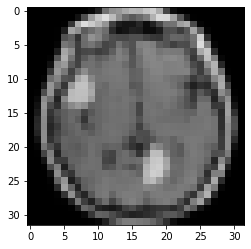

In [22]:
plt.imshow(reverse_transform(batch[21]))

# 1. Training Diffusion Models

In [23]:
train_losses = []
val_losses = []
# UNET training
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        # create a tensor timesteps with equaly parts in range [0, 299], T= 300
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        
        # Mark: Random noise
#         noise1 = torch.randn_like(batch_noisy)
        
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
#         loss = torch.nn.functional.mse_loss(noise1, predicted_noise) 
        
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        
        # Mark: Random noise
#         noise1 = torch.randn_like(batch_noisy)
        
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
#         loss = torch.nn.functional.mse_loss(noise1, predicted_noise) 
        
        mean_epoch_loss_val.append(loss.item())
    
    train_loss = np.mean(mean_epoch_loss)
    val_loss = np.mean(mean_epoch_loss_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"model_log/epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.30053952634334563 | Val Loss 0.1442668934663137
---
Epoch: 10 | Train Loss 0.03457921304636531 | Val Loss 0.0357078363498052
---
Epoch: 20 | Train Loss 0.030063654606540997 | Val Loss 0.025723127648234367
---
Epoch: 30 | Train Loss 0.025764667118589085 | Val Loss 0.028242812181512516
---
Epoch: 40 | Train Loss 0.024522220633096167 | Val Loss 0.022778769955039024
---
Epoch: 50 | Train Loss 0.026313103259437615 | Val Loss 0.02543762077887853
---
Epoch: 60 | Train Loss 0.023907328873044916 | Val Loss 0.02816569774101178
---
Epoch: 70 | Train Loss 0.024214033699697917 | Val Loss 0.028729147588213284
---
Epoch: 80 | Train Loss 0.023081117682158946 | Val Loss 0.02089257041613261
---
Epoch: 90 | Train Loss 0.022764727431866857 | Val Loss 0.02595026232302189
---
Epoch: 100 | Train Loss 0.020093952781624264 | Val Loss 0.01705544504026572
---
Epoch: 110 | Train Loss 0.022860654650462997 | Val Loss 0.020870418287813663
---
Epoch: 120 | Train Loss 0.019062264015277226 |

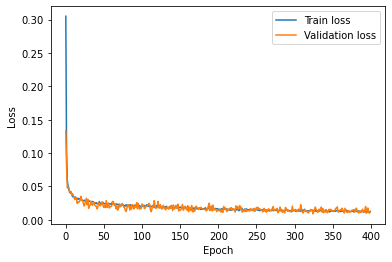

In [49]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### If traning more epochs

In [ ]:
# # TODO
# NO_EPOCHS = 10
# previous_epoch = 490
# # Load the saved state_dict
# unet.load_state_dict(torch.load(("model_log/epoch: 490")))

# # Continue training for more epochs
# for epoch in range(previous_epoch+1, NO_EPOCHS):
#     mean_epoch_loss = []
#     mean_epoch_loss_val = []
#     for batch, label in trainloader:
#         t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
#         batch = batch.to(device)
#         batch_noisy, noise = diffusion_model.forward(batch, t, device) 
#         predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

#         optimizer.zero_grad()
#         loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
#         mean_epoch_loss.append(loss.item())
#         loss.backward()
#         optimizer.step()

#     for batch, label in testloader:
#         t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
#         batch = batch.to(device)
#         batch_noisy, noise = diffusion_model.forward(batch, t, device) 
#         predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
#         loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
#         mean_epoch_loss_val.append(loss.item())

#     if epoch % PRINT_FREQUENCY == 0:
#         print('---')
#         print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
#         if VERBOSE:
#             with torch.no_grad():
#                 plot_noise_prediction(noise[0], predicted_noise[0])
#                 plot_noise_distribution(noise, predicted_noise)
                
#         torch.save(unet.state_dict(), f"epoch: {epoch}")


In [30]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("model_log/epoch: 430")))

<All keys matched successfully>

In [31]:
classes = ('0', '1')

In [32]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 10
IMAGE_SHAPE = (32,32)

# 2. Sampling

torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])


<Figure size 2304x2304 with 0 Axes>

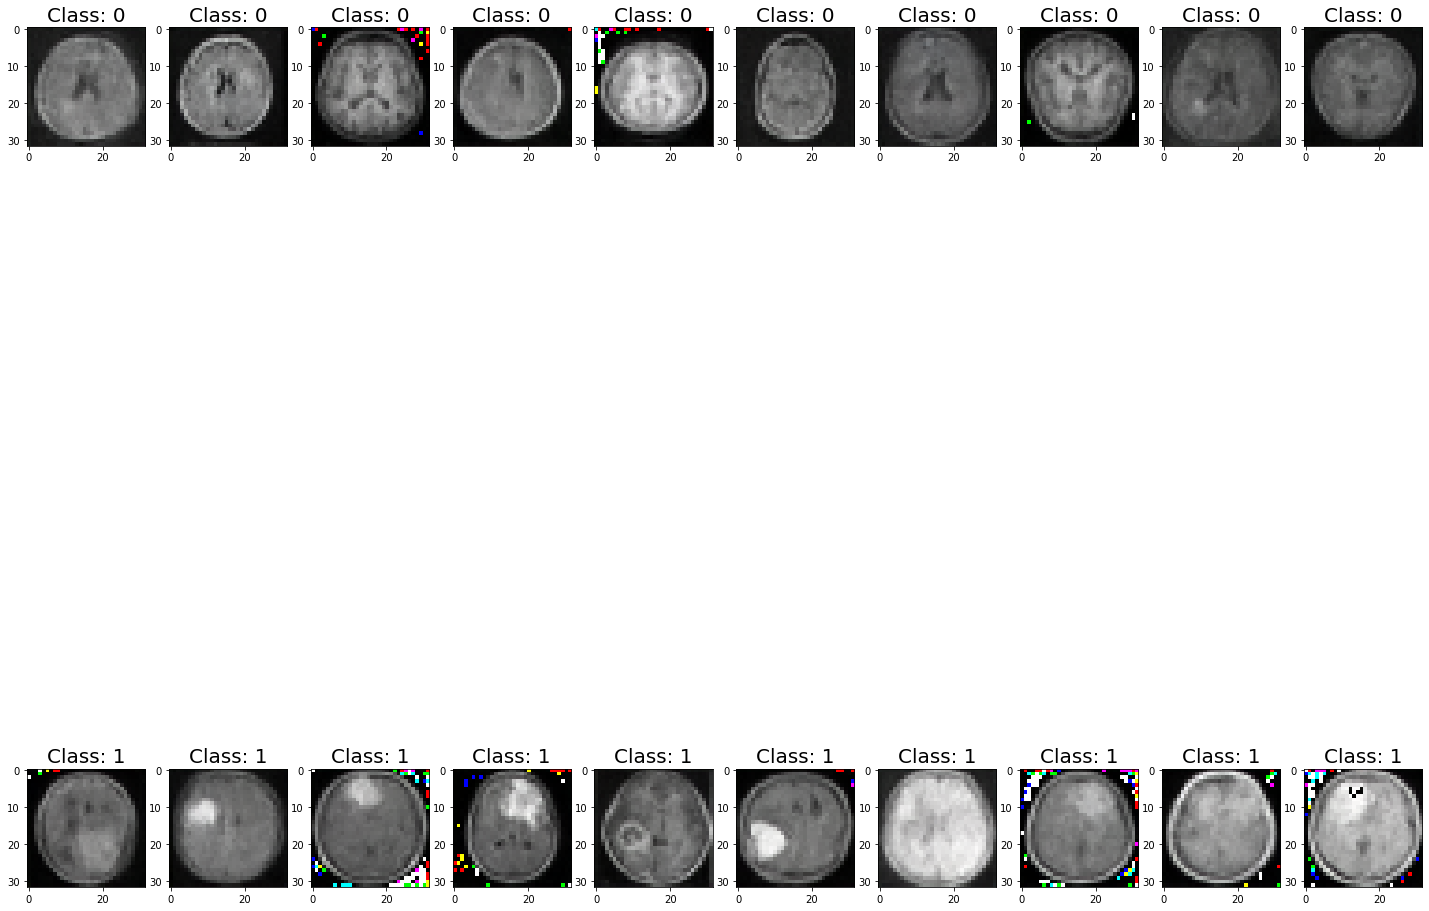

In [33]:
# torch.manual_seed(16)
# Sampling
plt.figure(figsize=(32,32))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (25,25))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
#         save_generated_images(imgs, 'generated_images')
    print (imgs.shape)
    for idx, img in enumerate(imgs):
#         print(ax[c][idx])
        ax[c][idx].imshow(reverse_transform(img))
#         plt.imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 20)
#         print(classes[c])
        
# plt.show()
plt.savefig("Output/without_preprocessed_600epochs_1000steps_condition_DF.svg")

In [171]:
# # Save generated images - TODO
# from datetime import datetime
# def save_generated_images(images, folder_name):
#     current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
#     folder_path = os.path.join(folder_name, current_time)
#     os.makedirs(folder_path, exist_ok=True)
    
#     for idx, img in enumerate(images):
#         file_name = f"generated_image_{idx}.png"
#         file_path = os.path.join(folder_path, file_name)
#         img = reverse_transform(img)
#         img.save(file_path)

In [54]:
trainloader1 = DataLoader(train_data, batch_size=2900, shuffle=True, drop_last=True)
batch, label = next(iter(trainloader1))
print(f"Feature batch shape: {batch.shape}")
print(f"Imgs batch shape: {imgs.shape}")

Feature batch shape: torch.Size([2900, 3, 32, 32])
Imgs batch shape: torch.Size([2900, 3, 32, 32])


In [55]:
# use CPU
from torchmetrics.image.fid import FrechetInceptionDistance

# fid = FrechetInceptionDistance(normalize=True, device=device)
fid = FrechetInceptionDistance(normalize=True)
fid.update(batch, real=True)
fid.update(imgs.cpu(), real=False)
print(f"FID: {float(fid.compute())}")
# FID: 86.99663543701172

FID: 86.99663543701172
